In [97]:
import re
import random
import requests
from requests.exceptions import RequestException
from datetime import datetime, timedelta
from typing import Optional, Tuple, List


import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [114]:
PATTERN = r"^PT(\d+)H$"


def extract_hours(window: str, pattern: str = PATTERN) -> int:
    match = re.match(pattern, window)
    if not match:
        raise ValueError(f"Window '{window}' does not match format 'PT(INTEGER)H'.")
    return int(match.group(1))


def get_station_measurements(
    uuid: str, reference_window: str = "PT6H", prediction_window: str = "PT1H"
) -> Tuple[Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """Get the water level measurements for the requested window and the selected uuid (station).

    Parameters
    ==========
    uuid: str
        The uuid of the station for which the measurements should be fetched.

    reference_window: str
        Window to be used to fetch reference data. Note that this
        window ends where the prediction_window starts.

    prediction_window: str
        Window (with respect to the current timestamp) to be
        used to fetch data for prediction (anomaly detection).

    Returns
    =======
    A tuple of two pandas dataframes or None.
    """

    current_ts = pd.to_datetime(datetime.now())  # This is already naive
    reference_hours = extract_hours(reference_window)
    prediction_hours = extract_hours(prediction_window)
    overall_window = f"PT{reference_hours+prediction_hours}H"

    url = (
        "https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations"
        f"/{uuid}/W/measurements.json?start={overall_window}"
    )
    try:
        res = requests.get(url)
        res.raise_for_status()
    except RequestException as e:
        return None, None

    measurements = res.json()
    if not measurements:
        return None, None

    df = pd.DataFrame(measurements)
    ref_cutoff = current_ts - timedelta(hours=prediction_hours)
    df["timestamp"] = pd.to_datetime(df["timestamp"]).dt.tz_localize(
        None
    )  # Ensure DataFrame timestamps are also naive
    ref_df = df[df["timestamp"] < ref_cutoff]
    pred_df = df[df["timestamp"] >= ref_cutoff]

    return ref_df, pred_df

In [115]:
# Get stations uuid
res = requests.get(
    f"https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations.json"
)
stations_uuid = [station["uuid"] for station in res.json()]

In [116]:
uuid = "b3492c68-8373-4769-9b29-22f66635a478"

df_ref, df_pred = get_station_measurements(
    uuid=uuid, reference_window="PT6H", prediction_window="PT1H"
)

if pred_df is None:
    print(
        "There are no new measurements for the requsted station. "
        "Please try agian later!"
    )
else:
    print("Fetching new measurements successful!")

Fetching new measurements successful!


In [119]:
df_pred.head()

,timestamp,value
361,2024-12-16 16:35:00,484.0
362,2024-12-16 16:36:00,484.0
363,2024-12-16 16:37:00,484.0
364,2024-12-16 16:38:00,484.0
365,2024-12-16 16:39:00,484.0


### Unsupervised Novelty Detection using the Local Outlier Factor (LOF)

Novelty detection is commonly applied in scenarios where you have a set of "normal" data without any anomalies, and the objective is to identify "new" or "novel" data points that deviate from this normal model. It does not assume contamination in the training data, meaning it presumes the reference data used to learn the normal behavior is free of outliers. Novelty detection is useful in contexts where the notion of "novel" is relative to a known baseline of normal and is applied as new data comes in.

Note that this is different from outlier detection where the assumption is that the dataset you are working with is mostly clean but may contain some outliers.

In [120]:
from sklearn.neighbors import LocalOutlierFactor

In [124]:
def detection(df_ref: pd.DataFrame, df_pred: pd.DataFrame) -> pd.DataFrame:
    assert "value" in df_ref, "Could not find 'value' among columns."
    assert "value" in df_pred, "Could not find 'value' among columns."
    # Initialize the novelty detection ML algorithm
    clf = LocalOutlierFactor(n_neighbors=2, novelty=True)
    # Feed the reference measurements to the ML model
    clf.fit(df_ref["value"].values.reshape(-1, 1))
    # Add a new column to the data frame holding the detection results (1 --> normal, -1 --> abnormal)
    df_pred["novelty"] = clf.predict(df_pred["value"].values.reshape(-1, 1))
    return df_pred


def plot_detection(df: pd.DataFrame) -> None:
    # Plotting
    plt.figure(figsize=(11, 7))

    # Extract the date from the first timestamp to include in the legend or title
    date_str = df["timestamp"].dt.date.iloc[0].strftime("%Y-%m-%d")

    # Plot normal points
    plt.scatter(
        df["timestamp"][df["novelty"] == 1],
        df["value"][df["novelty"] == 1],
        label=f"Normal",
        c="blue",
        marker="o",
    )

    # Plot outliers
    plt.scatter(
        df["timestamp"][df["novelty"] == -1],
        df["value"][df["novelty"] == -1],
        label="Novelty",
        c="red",
        marker="x",
    )

    # Set x-axis to display hours, minutes, and seconds
    plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M:%S"))

    plt.xlabel("Timestamp")
    plt.ylabel("Value")
    plt.title(f"Novelty Detection Results on  {date_str}")
    plt.legend()
    plt.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

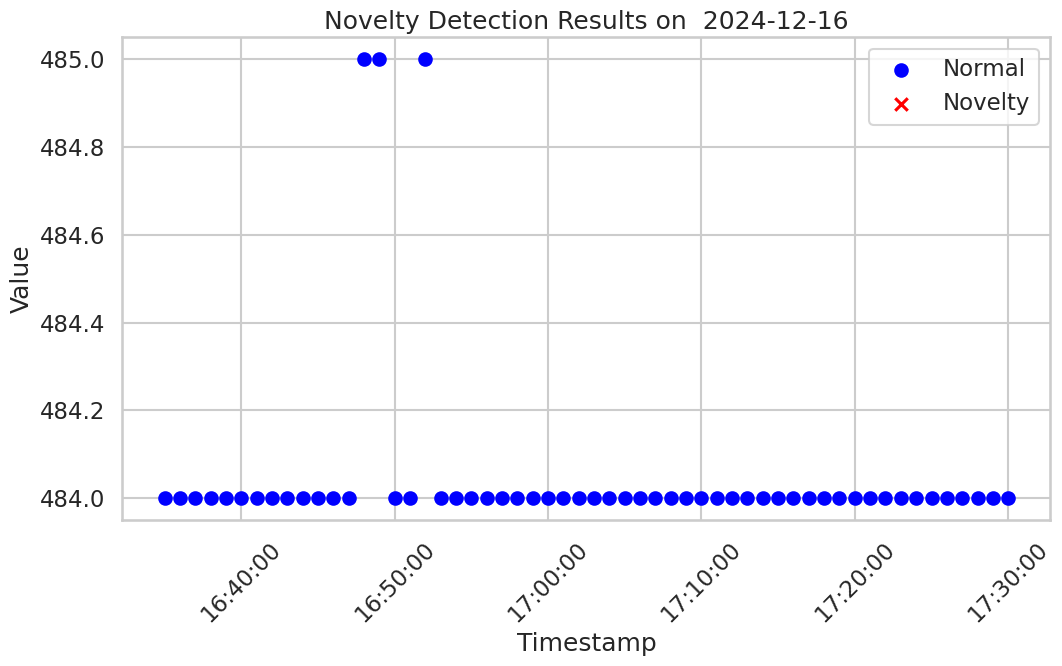

In [123]:
df_pred = detection(df_ref=df_ref, df_pred=df_pred)
plot_detection(df_pred)